In [16]:
import re
import pandas as pd
import subprocess


In [17]:
class ParameterOptmizer:
    def __init__(self):
        # define the experimental data
        self.exp_list = ['H2', 'CH4', 'C2H6', 'C2H4', 'C2H2', 'C3H8', 'C3H6', 'C4H10', 'C5H12', 
                        'C', 'CH', 'CH2', 'CH3', 'C2H3', 'C2H5', 'C3H7', 'H',
                        'CH3^+', 'CH4^+', 'CH5^+', 'C2H2^+', 'C2H4^+', 'C2H5^+', 'C2H6^+', 'C3H6^+', 'C3H8^+']
        self.exp_values = [5.319082, 90.80403, 2.428802, 0.197735, 0.171795, 0.717088, 0.046734, 
                          0.114829, 0.119573, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        # dictionary to save the current parameters
        self.current_parameters = {}
        self.load_current_parameters()
    
    def load_current_parameters(self):
        # kinet.inp 파일에서 현재 파라미터 값들을 읽어옴
        with open('kinet.inp', 'r') as f:
            content = f.readlines()

        for line in content:
            if "$ double precision, parameter :: f" in line:
                # f parameter와 값 추출
                pattern = r'f(\d+)\s*=\s*([\d.]+d-?\d+)'
                match = re.search(pattern, line)
                if match:
                    param_name = 'f' + match.group(1)
                    value = float(match.group(2).replace('d','e'))
                    self.current_parameters[param_name] = value

    def modify_parameter(self, param_name: str, new_value: float) -> None:
        # modify the parameter value in the kinet.inp file
        with open ('kinet.inp', 'r') as f:
            content = f.read()
        
        # modify the parameter
        pattern = f'(parameter :: {param_name} = )([\d.]+d-?\d+)'
        new_value_str = f'{new_value:.4e}'.replace('e', 'd')
        content = re.sub(pattern, f'\\1{new_value_str}', content)

        with open('kinet.inp', 'w') as f:
            f.write(content)
    
    def run_simulation(self) -> pd.DataFrame:
        # run simulatino and return the result
        # run manual.py
        subprocess.run(['python', 'manual.py'], capture_output=True)

        # read the result file
        species = []
        with open('qt_species_list.txt', 'r') as f:
            for line in f:
                comp = line[2:]
                species.append(comp.strip())
        
        df_sp = pd.read_csv('qt_densities.txt', sep=r'\s+', header=0, names=['Time [s]']+species)
        
        # calculate the concentration
        H2 = (df_sp['H2'])
        CH4 = (df_sp['CH4'] + df_sp['CH4(V13)'] + df_sp['CH4(V24)'])
        C2H2 = (df_sp['C2H2'] + df_sp['C2H2(V2)'] + df_sp['C2H2(V5)'] + df_sp['C2H2(V13)'])
        C2H4 = (df_sp['C2H4'] + df_sp['C2H4(V1)'] + df_sp['C2H4(V2)'])
        C2H6 = (df_sp['C2H6'] + df_sp['C2H6(V13)'] + df_sp['C2H6(V24)'])
        C3H6 = (df_sp['C3H6'] + df_sp['C3H6(V)'])
        C3H8 = (df_sp['C3H8'] + df_sp['C3H8(V1)'] + df_sp['C3H8(V2)'])
        C4H10 = (df_sp['C4H9H'])
        C5H12 = (df_sp['C5H12'])
        C = (df_sp['C'])
        CH = (df_sp['CH'])
        CH2 = (df_sp['CH2'])
        CH3 = (df_sp['CH3'])
        C2H3 = (df_sp['C2H3'])
        C2H5 = (df_sp['C2H5'])
        C3H7 = (df_sp['C3H7'])
        H = (df_sp['H'])
        CH3_plus = (df_sp['CH3^+'])
        CH4_plus = df_sp['CH4^+']
        CH5_plus = df_sp['CH5^+']
        C2H2_plus = df_sp['C2H2^+']
        C2H4_plus = df_sp['C2H4^+']
        C2H5_plus = df_sp['C2H5^+']
        C2H6_plus = df_sp['C2H6^+']
        C3H6_plus = df_sp['C3H6^+']
        C3H8_plus = df_sp['C3H8^+']

        all_sp = df_sp.sum(axis=1) - df_sp['E']

        t = abs(df_sp['Time [s]']-16.96).argmin()

        sim_H2 = float(format(H2.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        sim_CH4 = float(format(CH4.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        sim_C2H2 = float(format(C2H2.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        sim_C2H4 = float(format(C2H4.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        sim_C2H6 = float(format(C2H6.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        sim_C3H6 = float(format(C3H6.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        sim_C3H8 = float(format(C3H8.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        sim_C4H10 = float(format(C4H10.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        sim_C5H12 = float(format(C5H12.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        sim_C = float(format(C.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        sim_CH = float(format(CH.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        sim_CH2 = float(format(CH2.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        sim_CH3 = float(format(CH3.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        sim_C2H3 = float(format(C2H3.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        sim_C2H5 = float(format(C2H5.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        sim_C3H7 = float(format(C3H7.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        sim_H = float(format(H.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        sim_CH3_plus = float(format(CH3_plus.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        sim_CH4_plus = float(format(CH4_plus.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        sim_CH5_plus = float(format(CH5_plus.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        sim_C2H2_plus = float(format(C2H2_plus.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        sim_C2H4_plus = float(format(C2H4_plus.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        sim_C2H5_plus = float(format(C2H5_plus.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        sim_C2H6_plus = float(format(C2H6_plus.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        sim_C3H6_plus = float(format(C3H6_plus.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        sim_C3H8_plus = float(format(C3H8_plus.iloc[t]/all_sp.iloc[t]*100, '.6f'))
        
        result_df = pd.DataFrame({
            'species': self.exp_list,
            'exp': self.exp_values,
            'sim': [sim_H2, sim_CH4, sim_C2H6, sim_C2H4, sim_C2H2, sim_C3H8, sim_C3H6, sim_C4H10, sim_C5H12, 
                    sim_C, sim_CH, sim_CH2, sim_CH3, sim_C2H3, sim_C2H5, sim_C3H7, sim_H,  # 라디칼 종
                    sim_CH3_plus, sim_CH4_plus, sim_CH5_plus, sim_C2H2_plus, sim_C2H4_plus, 
                    sim_C2H5_plus, sim_C2H6_plus, sim_C3H6_plus, sim_C3H8_plus]  # 이온 종
        })

        return result_df    

    def Print_Result(self):
        print(self.run_simulation())


<>:34: SyntaxWarning: invalid escape sequence '\d'
<>:34: SyntaxWarning: invalid escape sequence '\d'
C:\Users\bsjun\AppData\Local\Temp\ipykernel_27448\3147381160.py:34: SyntaxWarning: invalid escape sequence '\d'
  pattern = f'(parameter :: {param_name} = )([\d.]+d-?\d+)'


In [18]:
if __name__ == "__main__":
    optimizer = ParameterOptmizer()
    optimizer.run_simulation()

C:\Users\USER\AppData\Local\Temp\ipykernel_4000\330235517.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv('qt_conditions.txt', delim_whitespace=True)


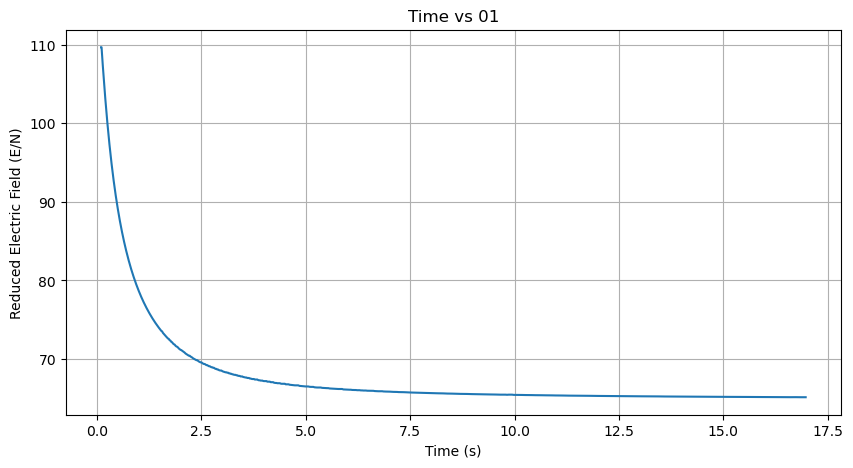

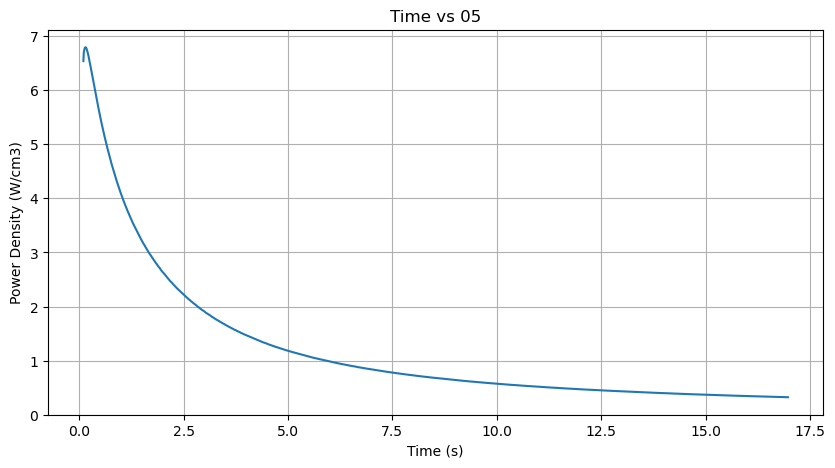

In [6]:
# qt_conditions.txt 파일 읽기
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv('qt_conditions.txt', delim_whitespace=True)

# 열 이름 설정
data.columns = ['Time_s', '01', '02', '03', '04', '05']

# Time_s vs 01 그래프
plt.figure(figsize=(10,5))
plt.plot(data[data['Time_s'] >= 0.1]['Time_s'], data[data['Time_s'] >= 0.1]['01'])
plt.xlabel('Time (s)')
plt.ylabel('Reduced Electric Field (E/N)')
plt.title('Time vs 01')
plt.grid(True)
plt.show()

# Time_s vs 05 그래프 
plt.figure(figsize=(10,5))
plt.plot(data[data['Time_s'] >= 0.1]['Time_s'], data[data['Time_s'] >= 0.1]['05'])
plt.xlabel('Time (s)') 
plt.ylabel('Power Density (W/cm3)')
plt.title('Time vs 05')
plt.grid(True)
plt.show()

